In [1]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from main.utils import data_manage_utils, train_utils

importlib.reload(train_utils)
importlib.reload(data_manage_utils)

loading_folder = "2024_06_17-0642"
loading_spec = "RF"

ROOT_PATH = os.path.abspath("../../")
TRAIN_DATA_FOLDER = os.path.join(ROOT_PATH, "data/training/training_results/", loading_spec, loading_folder)

# Finding corresponding prep data folder
settings_path = os.path.join(TRAIN_DATA_FOLDER, "estimation_settings.json")
PREP_DATA_FOLDER = data_manage_utils.find_data_path_by_settings_file(settings_path,ROOT_PATH)

In [2]:
pert_result_df_path = os.path.join(TRAIN_DATA_FOLDER,"pert_out_df.pkl.gz")

pert_df = pd.read_pickle(pert_result_df_path, compression="gzip")

pert_cols = list(set(pert_df.columns) - {"ARR_MIN_OF_DAY_COS", "ARR_MIN_OF_DAY_SIN", "ARR_DAY_SIN", "ARR_DAY_COS"})
USE_TH = False
if USE_TH:
    pert_cols = ["TEMP(C)","WIND_SPEED(KMH)","REL_HUMIDITY(PERCENT)","WIND_DRCT(DEG)", "SEA_LEVEL_PRESSURE(MILLIBAR)"]

pert_df

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC),y_true,pert_id,level,y
0,77.0,51.0,64.0,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
1,62.0,51.0,64.0,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
2,66.0,51.0,64.0,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
3,70.0,51.0,64.0,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
4,73.0,51.0,64.0,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501874,2.0,69.0,96.0,0.433884,-0.900969,0.594823,-0.803857,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.78,0,RUNWAY_ERROR(PERC)<6600848>,3,1
10501875,2.0,69.0,96.0,0.433884,-0.900969,0.594823,-0.803857,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.82,0,RUNWAY_ERROR(PERC)<6600848>,3,1
10501876,2.0,69.0,96.0,0.433884,-0.900969,0.594823,-0.803857,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.85,0,RUNWAY_ERROR(PERC)<6600848>,3,1
10501877,2.0,69.0,96.0,0.433884,-0.900969,0.594823,-0.803857,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.88,0,RUNWAY_ERROR(PERC)<6600848>,3,1


In [3]:
pert_df[pert_df["pert_id"].isin(["TEMP(C)"])]

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC),y_true,pert_id,level,y


In [4]:
y_test_pred = pd.DataFrame(data_manage_utils.load_numpy_from_pickle(os.path.join(TRAIN_DATA_FOLDER, "y_test_pred.pkl")))
y_test_pred

,0
0,2
1,0
2,1
3,2
4,0
...,...
65796,1
65797,1
65798,2
65799,0


In [5]:
X_test = pd.read_pickle(os.path.join(PREP_DATA_FOLDER, "X_test_df.pkl"))
y_test = pd.DataFrame(pd.read_pickle(os.path.join(PREP_DATA_FOLDER, "y_test_df.pkl")))
X_test

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
6386798,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
6824913,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.4
7556876,-2,86,51,0.000000,1.000000,-0.768842,-0.639439,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.2
10772416,162,95,84,0.000000,1.000000,0.480989,-0.876727,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,0.0
7282245,-11,181,63,-0.433884,-0.900969,-0.942641,-0.333807,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980295,-3,102,68,-0.433884,-0.900969,0.731354,-0.681998,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.8
9983451,-3,115,30,-0.433884,-0.900969,-0.342020,0.939693,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
7026317,54,86,75,0.781831,0.623490,-0.816642,0.577145,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
10352441,2,150,53,0.000000,1.000000,-0.980785,0.195090,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.4


In [6]:
y_test

,ARR_DELAY_MINS
6386798,2
6824913,0
7556876,1
10772416,2
7282245,0
...,...
9980295,1
9983451,1
7026317,2
10352441,1


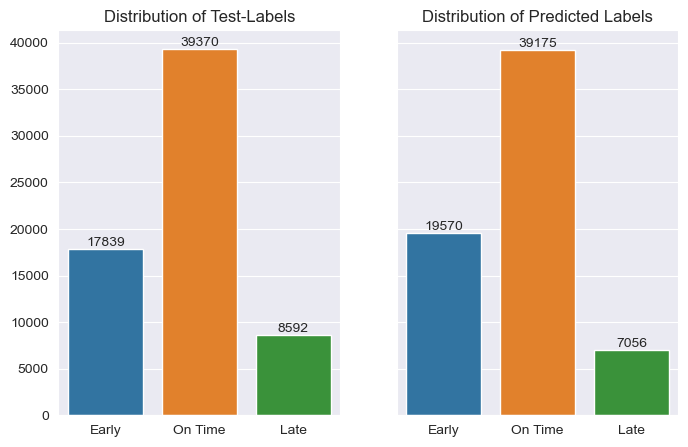

In [7]:
fig, axes = plt.subplots(1,2,figsize=(8,5), sharey=True)
sns.barplot(x=["Early", "On Time", "Late"], y=list(y_test.value_counts().sort_index()), ax=axes[0])
sns.barplot(x=["Early", "On Time", "Late"], y=list(y_test_pred.value_counts().sort_index()), ax=axes[1])
axes[0].set_title("Distribution of Test-Labels")
axes[1].set_title("Distribution of Predicted Labels")
axes[0].bar_label(axes[0].containers[0])
axes[1].bar_label(axes[1].containers[0])
plt.show()

In [8]:
def print_measures(y_pred, y_true, true_labels):
    if type(y_pred) == pd.DataFrame:
        y_pred = y_pred[y_pred.columns[0]]
    if type(y_true) == pd.DataFrame:
        y_true = y_true[y_true.columns[0]]
    ret_dict = {}
    print(20*"-")
    print(f"Global measures")
    print(f"Number of entries: {len(y_pred)}")
    acc = accuracy_score(y_true=y_true, y_pred=y_pred, normalize=True)
    ret_dict.update({"acc" : acc})
    print(f"Accuracy: {acc:.5f}")
    print(f"Precision-µ: {precision_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print(f"Recall-µ: {recall_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print(f"F1-Score-µ: {f1_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print("=")
    print(f"Precision-M: {precision_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    print(f"Recall-M: {recall_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    print(f"F1-Score-M: {f1_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    for label in true_labels:
        if (label in y_pred) or (label in y_true):
            y_pred_filtered = [1 if val == label else 0 for val in y_pred]
            y_true_filtered = [1 if val == label else 0 for val in y_true]
            print(20*"-")
            print(f"Measures for label '{label}'")
            print(f"Number of entries: {sum(y_true_filtered)}")
            prec = precision_score(y_true=y_true_filtered, y_pred=y_pred_filtered)
            print(f"Precision score: {prec:.5f}")
            print(f"Recall score: {recall_score(y_true=y_true_filtered, y_pred=y_pred_filtered):.5f}")
            ret_dict.update({"prec"+str(label) : prec})
    return ret_dict
real = print_measures(y_test_pred, y_test, [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73429
Precision-µ: 0.73429
Recall-µ: 0.73429
F1-Score-µ: 0.73429
=
Precision-M: 0.75099
Recall-M: 0.71565
F1-Score-M: 0.73029
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.58298
Recall score: 0.63955
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.78223
Recall score: 0.77836
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.88776
Recall score: 0.72905


## Finding amount of alerts in the data.
The 2 tables below depict the amount of alarmed perturbation cases within the result data.
The first table groups the data, such that only the predicted target with its min and max value within a given perturbation scenario is printed. 
This is used to find scenarios, where the min and max values deviate which means that the perturbation lead to varying results

In [9]:
X_pert_res = pert_df.groupby("pert_id").agg({'y':['min','max']})["y"]
X_pert_res

,min,max
pert_id,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,1
1HOUR_PRECIPITATION(INCH)<10003947>,1,1
1HOUR_PRECIPITATION(INCH)<10004727>,1,1
1HOUR_PRECIPITATION(INCH)<10006126>,1,1
1HOUR_PRECIPITATION(INCH)<10006791>,1,1
...,...,...
WINGLETS(YN)<9998396>,0,0
WINGLETS(YN)<9998430>,2,2
WINGLETS(YN)<9998460>,1,1


In [10]:
pert_alerts = X_pert_res[~(X_pert_res["min"] == X_pert_res["max"])]
pert_alerts

,min,max
pert_id,,
1HOUR_PRECIPITATION(INCH)<10026093>,0,1
1HOUR_PRECIPITATION(INCH)<10042426>,0,1
1HOUR_PRECIPITATION(INCH)<10042665>,0,1
1HOUR_PRECIPITATION(INCH)<10055239>,0,1
1HOUR_PRECIPITATION(INCH)<10055441>,0,1
...,...,...
WINGLETS(YN)<9950165>,0,1
WINGLETS(YN)<9966554>,0,1
WINGLETS(YN)<9969420>,0,1


Now we want to find all single perturbation rows within the result and find all that are related to the alarmed scenarios.

In [11]:
list(pert_alerts.index)
pert_df[pert_df["pert_id"].isin(list(pert_alerts.index))]

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC),y_true,pert_id,level,y
9,-7.0,95.0,72.0,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
10,-22.0,95.0,72.0,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
11,-18.0,95.0,72.0,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
12,-14.0,95.0,72.0,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
13,-11.0,95.0,72.0,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501199,13.0,225.0,7.0,-0.974928,-0.222521,-0.321439,0.946930,261.132,12.624816,1445.094760,...,0,0,0,0,0,0.18,1,RUNWAY_ERROR(PERC)<6123357>,3,0
10501200,13.0,225.0,7.0,-0.974928,-0.222521,-0.321439,0.946930,261.132,12.624816,1445.094760,...,0,0,0,0,0,0.22,1,RUNWAY_ERROR(PERC)<6123357>,3,0
10501201,13.0,225.0,7.0,-0.974928,-0.222521,-0.321439,0.946930,261.132,12.624816,1445.094760,...,0,0,0,0,0,0.25,1,RUNWAY_ERROR(PERC)<6123357>,3,0
10501202,13.0,225.0,7.0,-0.974928,-0.222521,-0.321439,0.946930,261.132,12.624816,1445.094760,...,0,0,0,0,0,0.28,1,RUNWAY_ERROR(PERC)<6123357>,3,0


## Creating the Ourcome DF
Usign the last four columns in the above df, we see the mode, index and results of ALL perturbation scenarios. Not only the alarmed values. 

In [12]:
pert_outcomes = pert_df[pert_df.columns[-4:]]
pert_outcomes

,y_true,pert_id,level,y
0,2,DEP_DELAY(MINS)<6386798>,1,2
1,2,DEP_DELAY(MINS)<6386798>,1,2
2,2,DEP_DELAY(MINS)<6386798>,1,2
3,2,DEP_DELAY(MINS)<6386798>,1,2
4,2,DEP_DELAY(MINS)<6386798>,1,2
...,...,...,...,...
10501874,0,RUNWAY_ERROR(PERC)<6600848>,3,1
10501875,0,RUNWAY_ERROR(PERC)<6600848>,3,1
10501876,0,RUNWAY_ERROR(PERC)<6600848>,3,1
10501877,0,RUNWAY_ERROR(PERC)<6600848>,3,1


## Disassembling the perturbation ID colun to make it more readable and get index and column label information

In [13]:
def disassemble_pert_id(row):
    s = row["pert_id"].split("<")
    col = s[0]
    idx = s[1][:-1]
    val = row[col]
    return [col,val,idx]

col_values = pert_df.apply(lambda row: disassemble_pert_id(row), axis=1)

In [14]:
col_values = pd.DataFrame(list(col_values.to_numpy()), columns=["column","val","idx"])
col_values

,column,val,idx
0,DEP_DELAY(MINS),77.00,6386798
1,DEP_DELAY(MINS),62.00,6386798
2,DEP_DELAY(MINS),66.00,6386798
3,DEP_DELAY(MINS),70.00,6386798
4,DEP_DELAY(MINS),73.00,6386798
...,...,...,...
10501874,RUNWAY_ERROR(PERC),0.78,6600848
10501875,RUNWAY_ERROR(PERC),0.82,6600848
10501876,RUNWAY_ERROR(PERC),0.85,6600848
10501877,RUNWAY_ERROR(PERC),0.88,6600848


In [15]:
col_values[col_values["column"] == "REL_HUMIDITY(PERCENT)"]

,column,val,idx
4880765,REL_HUMIDITY(PERCENT),93.180000,6386798
4880766,REL_HUMIDITY(PERCENT),88.106349,6386798
4880767,REL_HUMIDITY(PERCENT),89.374762,6386798
4880768,REL_HUMIDITY(PERCENT),90.643175,6386798
4880769,REL_HUMIDITY(PERCENT),91.911587,6386798
...,...,...,...
5481268,REL_HUMIDITY(PERCENT),57.900000,6600848
5481269,REL_HUMIDITY(PERCENT),58.900000,6600848
5481270,REL_HUMIDITY(PERCENT),59.800000,6600848
5481271,REL_HUMIDITY(PERCENT),60.800000,6600848


In [16]:
pert_outcomes["column"] = list(col_values["column"])
pert_outcomes["val"] = list(col_values["val"])
pert_outcomes["idx"] = list(col_values["idx"])
pert_outcomes

C:\Users\chrig\AppData\Local\Temp\ipykernel_6040\1567013798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pert_outcomes["column"] = list(col_values["column"])
C:\Users\chrig\AppData\Local\Temp\ipykernel_6040\1567013798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pert_outcomes["val"] = list(col_values["val"])
C:\Users\chrig\AppData\Local\Temp\ipykernel_6040\1567013798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,y_true,pert_id,level,y,column,val,idx
0,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),77.00,6386798
1,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),62.00,6386798
2,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),66.00,6386798
3,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),70.00,6386798
4,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),73.00,6386798
...,...,...,...,...,...,...,...
10501874,0,RUNWAY_ERROR(PERC)<6600848>,3,1,RUNWAY_ERROR(PERC),0.78,6600848
10501875,0,RUNWAY_ERROR(PERC)<6600848>,3,1,RUNWAY_ERROR(PERC),0.82,6600848
10501876,0,RUNWAY_ERROR(PERC)<6600848>,3,1,RUNWAY_ERROR(PERC),0.85,6600848
10501877,0,RUNWAY_ERROR(PERC)<6600848>,3,1,RUNWAY_ERROR(PERC),0.88,6600848


In [17]:
pert_view = pert_outcomes.groupby(["pert_id","y_true"]).first().reset_index().set_index('pert_id')
pert_view

,y_true,level,y,column,val,idx
pert_id,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791
...,...,...,...,...,...,...
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396
WINGLETS(YN)<9998430>,2,1,2,WINGLETS(YN),1.000,9998430
WINGLETS(YN)<9998460>,1,1,1,WINGLETS(YN),0.000,9998460


## Create pert_alarm column
The pert_view DataFrame has been established. Now we add some flags to easily find whether or not a given entry is part of a "alarmed" entry or not.   

In [18]:
pert_view["pert_alarm"] = [idx in pert_alerts.index for idx in pert_view.index]
faulty = pert_view[pert_view["y_true"] != pert_view["y"]]
faulty_and_changed = faulty[faulty["pert_alarm"]]
pert_view["class_error"] = [idx in faulty.index for idx in pert_view.index]
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False
...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396,False,False
WINGLETS(YN)<9998430>,2,1,2,WINGLETS(YN),1.000,9998430,False,False
WINGLETS(YN)<9998460>,1,1,1,WINGLETS(YN),0.000,9998460,False,False


In [19]:
pert_view[pert_view["pert_alarm"]]

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10026093,True,True
1HOUR_PRECIPITATION(INCH)<10042426>,0,3,0,1HOUR_PRECIPITATION(INCH),0.0,10042426,True,False
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10042665,True,True
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10055239,True,True
1HOUR_PRECIPITATION(INCH)<10055441>,0,3,0,1HOUR_PRECIPITATION(INCH),0.0,10055441,True,False
...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9950165>,0,1,1,WINGLETS(YN),1.0,9950165,True,True
WINGLETS(YN)<9966554>,0,1,1,WINGLETS(YN),0.0,9966554,True,True
WINGLETS(YN)<9969420>,1,1,1,WINGLETS(YN),0.0,9969420,True,False


In [20]:
_t = pert_view[(pert_view["y"] == 0) | (pert_view["y"] == 2)]
_t 

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10007195>,2,3,2,1HOUR_PRECIPITATION(INCH),0.475,10007195,False,False
1HOUR_PRECIPITATION(INCH)<10007286>,2,3,2,1HOUR_PRECIPITATION(INCH),0.035,10007286,False,False
1HOUR_PRECIPITATION(INCH)<10007352>,2,3,2,1HOUR_PRECIPITATION(INCH),0.010,10007352,False,False
1HOUR_PRECIPITATION(INCH)<10007615>,1,3,2,1HOUR_PRECIPITATION(INCH),0.010,10007615,False,True
1HOUR_PRECIPITATION(INCH)<10007880>,2,3,2,1HOUR_PRECIPITATION(INCH),0.010,10007880,False,False
...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9998109>,2,1,2,WINGLETS(YN),1.000,9998109,False,False
WINGLETS(YN)<9998159>,1,1,0,WINGLETS(YN),1.000,9998159,False,True
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396,False,False


In [21]:
#X_test.loc[[10026093, 10022088]].to_csv("result.csv", sep=",")

# MARKER FOR CSV PRINT

In [22]:
#y_test_pred.iloc[X_test.index.get_loc(10026093)]

## First measures for subsets on perturbation data. Option per option view

In [23]:
counts = pert_view[pert_view["pert_alarm"]]["column"].value_counts()
percs = pert_view[pert_view["pert_alarm"]]["column"].value_counts(normalize=True)*100
pd.concat([counts, percs], axis=1, keys=['count', 'percenage'])

,count,percenage
DEP_DELAY(MINS),48171,60.338198
1HOUR_PRECIPITATION(INCH),4740,5.937246
CRS_ELAPSED_TIME(MINS),4677,5.858333
EVENT_RA,3756,4.704703
EVENT_SN,2974,3.725183
APPROACH_SPEED(KMH),2658,3.329367
REL_HUMIDITY(PERCENT),2463,3.085113
WIND_SPEED(KMH),1883,2.358615
SEA_LEVEL_PRESSURE(MILLIBAR),1477,1.850066
NR_PREV_ARR_FLIGHTS(1HR),1366,1.711029


Find number of alarms by level

In [24]:
counts_total = pert_view["level"].value_counts()
counts = pert_view[pert_view["pert_alarm"]]["level"].value_counts()
percs = (counts / counts_total) *100
#perc_of_all = pd.DataFrame([x/len(pert_view)*100 for x in counts])
pd.concat([counts_total,counts, percs], axis=1, keys=['total # of options', '# of alarming options', 'alarm percentages'])

,total # of options,# of alarming options,alarm percentages
1,987015,62393,6.321383
3,592209,13677,2.309489
2,197403,3765,1.907266


In [25]:
print(f"All lvl 1 pert columns: ")
print(list(pert_view[(pert_view["level"] == 1)]["column"].unique()))
print(f"Alarmed lvl 1 pert columns: ")
print(list(pert_view[(pert_view["level"] == 1) & (pert_view["pert_alarm"] == True)]["column"].unique()))

All lvl 1 pert columns: 
['CRS_ELAPSED_TIME(MINS)', 'DEP_DELAY(MINS)', 'EVENT_BR', 'EVENT_DZ', 'EVENT_FG', 'EVENT_FU', 'EVENT_GR', 'EVENT_GS', 'EVENT_HZ', 'EVENT_IC', 'EVENT_RA', 'EVENT_SN', 'EVENT_TS', 'NR_PREV_ARR_FLIGHTS(1HR)', 'WINGLETS(YN)']
Alarmed lvl 1 pert columns: 
['CRS_ELAPSED_TIME(MINS)', 'DEP_DELAY(MINS)', 'EVENT_BR', 'EVENT_DZ', 'EVENT_FG', 'EVENT_FU', 'EVENT_HZ', 'EVENT_IC', 'EVENT_RA', 'EVENT_SN', 'EVENT_TS', 'NR_PREV_ARR_FLIGHTS(1HR)', 'WINGLETS(YN)']


In [26]:
print(f"All lvl 3 pert columns: ")
print(list(pert_view[(pert_view["level"] == 3)]["column"].unique()))
print(f"Alarmed lvl 3 pert columns: ")
print(list(pert_view[(pert_view["level"] == 3) & (pert_view["pert_alarm"] == True)]["column"].unique()))

All lvl 3 pert columns: 
['1HOUR_PRECIPITATION(INCH)', 'DEWPOINT_TEMP(C)', 'REL_HUMIDITY(PERCENT)', 'RUNWAY_ERROR(PERC)', 'SEA_LEVEL_PRESSURE(MILLIBAR)', 'TEMP(C)', 'VISIBILITY(MILES)', 'WIND_DRCT(DEG)', 'WIND_SPEED(KMH)']
Alarmed lvl 3 pert columns: 
['1HOUR_PRECIPITATION(INCH)', 'DEWPOINT_TEMP(C)', 'REL_HUMIDITY(PERCENT)', 'RUNWAY_ERROR(PERC)', 'SEA_LEVEL_PRESSURE(MILLIBAR)', 'TEMP(C)', 'VISIBILITY(MILES)', 'WIND_DRCT(DEG)', 'WIND_SPEED(KMH)']


In [27]:
pert_view[(pert_view['level'] == 3) & pert_view['pert_alarm']]

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10026093,True,True
1HOUR_PRECIPITATION(INCH)<10042426>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042426,True,False
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042665,True,True
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055239,True,True
1HOUR_PRECIPITATION(INCH)<10055441>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055441,True,False
...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9981281>,1,3,1,WIND_SPEED(KMH),9.260,9981281,True,False
WIND_SPEED(KMH)<9983451>,1,3,1,WIND_SPEED(KMH),14.816,9983451,True,False
WIND_SPEED(KMH)<9985126>,1,3,0,WIND_SPEED(KMH),13.890,9985126,True,True


All columns are present when looking into the perturbation levels

In [28]:
lvl3_and_alarmed = pert_view[(pert_view['level'] == 3) & pert_view['pert_alarm'] == True]
lvl3_and_not_alarmed = pert_view[(pert_view['level'] == 3) & pert_view['pert_alarm'] == False]

if 1 in pert_view["level"].values:
    lvl1_and_alarmed = pert_view[(pert_view['level'] == 1) & pert_view['pert_alarm'] == True]
    lvl1_and_not_alarmed = pert_view[(pert_view['level'] == 1) & pert_view['pert_alarm'] == False]

    print(f"Pert lvl 1 accuracy within alarmed values:\n\t{(len(lvl1_and_alarmed[lvl1_and_alarmed['class_error'] == False]) / len(lvl1_and_alarmed)) * 100:.2f}%")
    print(f"Pert lvl 1 accuracy within non-alarmed values:\n\t{(len(lvl1_and_not_alarmed[lvl1_and_not_alarmed['class_error'] == False]) / len(lvl1_and_not_alarmed)) * 100:.2f}%")
    print(40*"=")
print(f"Pert lvl 3 accuracy within alarmed values:\n\t{(len(lvl3_and_alarmed[lvl3_and_alarmed['class_error'] == False]) / len(lvl3_and_alarmed)) * 100:.2f}%")
print(f"Pert lvl 3 accuracy within non-alarmed values:\n\t{(len(lvl3_and_not_alarmed[lvl3_and_not_alarmed['class_error'] == False]) / len(lvl3_and_not_alarmed)) * 100:.2f}%")

Pert lvl 1 accuracy within alarmed values:
	64.12%
Pert lvl 1 accuracy within non-alarmed values:
	73.77%
Pert lvl 3 accuracy within alarmed values:
	49.44%
Pert lvl 3 accuracy within non-alarmed values:
	73.62%


In [29]:
pert_view[pert_view['pert_alarm'] & pert_view['class_error']]

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10026093,True,True
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10042665,True,True
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10055239,True,True
1HOUR_PRECIPITATION(INCH)<10055554>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10055554,True,True
1HOUR_PRECIPITATION(INCH)<10055618>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10055618,True,True
...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9927066>,0,1,1,WINGLETS(YN),1.0,9927066,True,True
WINGLETS(YN)<9929965>,1,1,2,WINGLETS(YN),0.0,9929965,True,True
WINGLETS(YN)<9950165>,0,1,1,WINGLETS(YN),1.0,9950165,True,True


In [30]:
# Prepare values.
total = len(pert_view)
error = len(pert_view[pert_view['class_error']])
no_error = len(pert_view[~pert_view['class_error']])
alarm = len(pert_view[pert_view['pert_alarm']])
no_alarm = len(pert_view[~pert_view['pert_alarm']])
# Combined
alarm_and_error = len(pert_view[pert_view['pert_alarm'] & pert_view['class_error']])
alarm_and_no_error = len(pert_view[pert_view['pert_alarm'] & ~pert_view['class_error']])
no_alarm_and_error = len(pert_view[~pert_view['pert_alarm'] & pert_view['class_error']])
no_alarm_and_no_error = len(pert_view[~pert_view['pert_alarm'] & ~pert_view['class_error']])

print(f"Basics:\n{40*'-'}")
print(f"Accuracy for all perturbation options: {(1 - error/total)*100:.3f}%")
print(f"Nr. of perturbation alarms for all perturbation options: {(alarm/total)*100:.3f}%")
print(40*"=")
print(f"Combined metrics:\n{40*'-'}")
print(f"Of all wrong classifications, % of alarmed cases: {(alarm_and_error/error)*100:.3f}%")
print(f"Of all true classifications, % of alarmed cases: {(alarm_and_no_error/no_error)*100:.3f}%")
print(40*'-')
print(f"Of all alarmed, % of true classifications: {(alarm_and_no_error/alarm)*100:.3f}%")
print(f"Of all alarmed, % of wrong classifications: {(alarm_and_error/alarm)*100:.3f}%")
print(40*'-')
print(f"Of all non-alarmed, % of true classifications: {(no_alarm_and_no_error/no_alarm)*100:.3f}%")
print(f"Of all non-alarmed, % of wrong classifications: {(no_alarm_and_error/no_alarm)*100:.3f}%")
print(40*'-')

Basics:
----------------------------------------
Accuracy for all perturbation options: 73.429%
Nr. of perturbation alarms for all perturbation options: 4.494%
Combined metrics:
----------------------------------------
Of all wrong classifications, % of alarmed cases: 6.612%
Of all true classifications, % of alarmed cases: 3.727%
----------------------------------------
Of all alarmed, % of true classifications: 60.906%
Of all alarmed, % of wrong classifications: 39.094%
----------------------------------------
Of all non-alarmed, % of true classifications: 74.018%
Of all non-alarmed, % of wrong classifications: 25.982%
----------------------------------------


In [31]:
cols = list(pert_view["column"].value_counts().index)
cols

['1HOUR_PRECIPITATION(INCH)',
 'EVENT_SN',
 'WIND_SPEED(KMH)',
 'WIND_DRCT(DEG)',
 'VISIBILITY(MILES)',
 'TEMP(C)',
 'TAIL_HEIGHT(M)',
 'SEA_LEVEL_PRESSURE(MILLIBAR)',
 'RUNWAY_ERROR(PERC)',
 'REL_HUMIDITY(PERCENT)',
 'PARKING_AREA(SQM)',
 'NR_PREV_ARR_FLIGHTS(1HR)',
 'EVENT_TS',
 'EVENT_RA',
 'APPROACH_SPEED(KMH)',
 'EVENT_IC',
 'EVENT_HZ',
 'EVENT_GS',
 'EVENT_GR',
 'EVENT_FU',
 'EVENT_FG',
 'EVENT_DZ',
 'EVENT_BR',
 'DEWPOINT_TEMP(C)',
 'DEP_DELAY(MINS)',
 'CRS_ELAPSED_TIME(MINS)',
 'WINGLETS(YN)']

C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new ar

,y_true,level,y,column,val,pert_alarm,class_error
idx,,,,,,,
10001243,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,False,False
10003947,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,False,False
10004727,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,False,False
10006126,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,False,False
10006791,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,False,False
...,...,...,...,...,...,...,...
9998396,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,False,False
9998430,2,3,2,1HOUR_PRECIPITATION(INCH),0.000,False,False
9998460,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,False,False


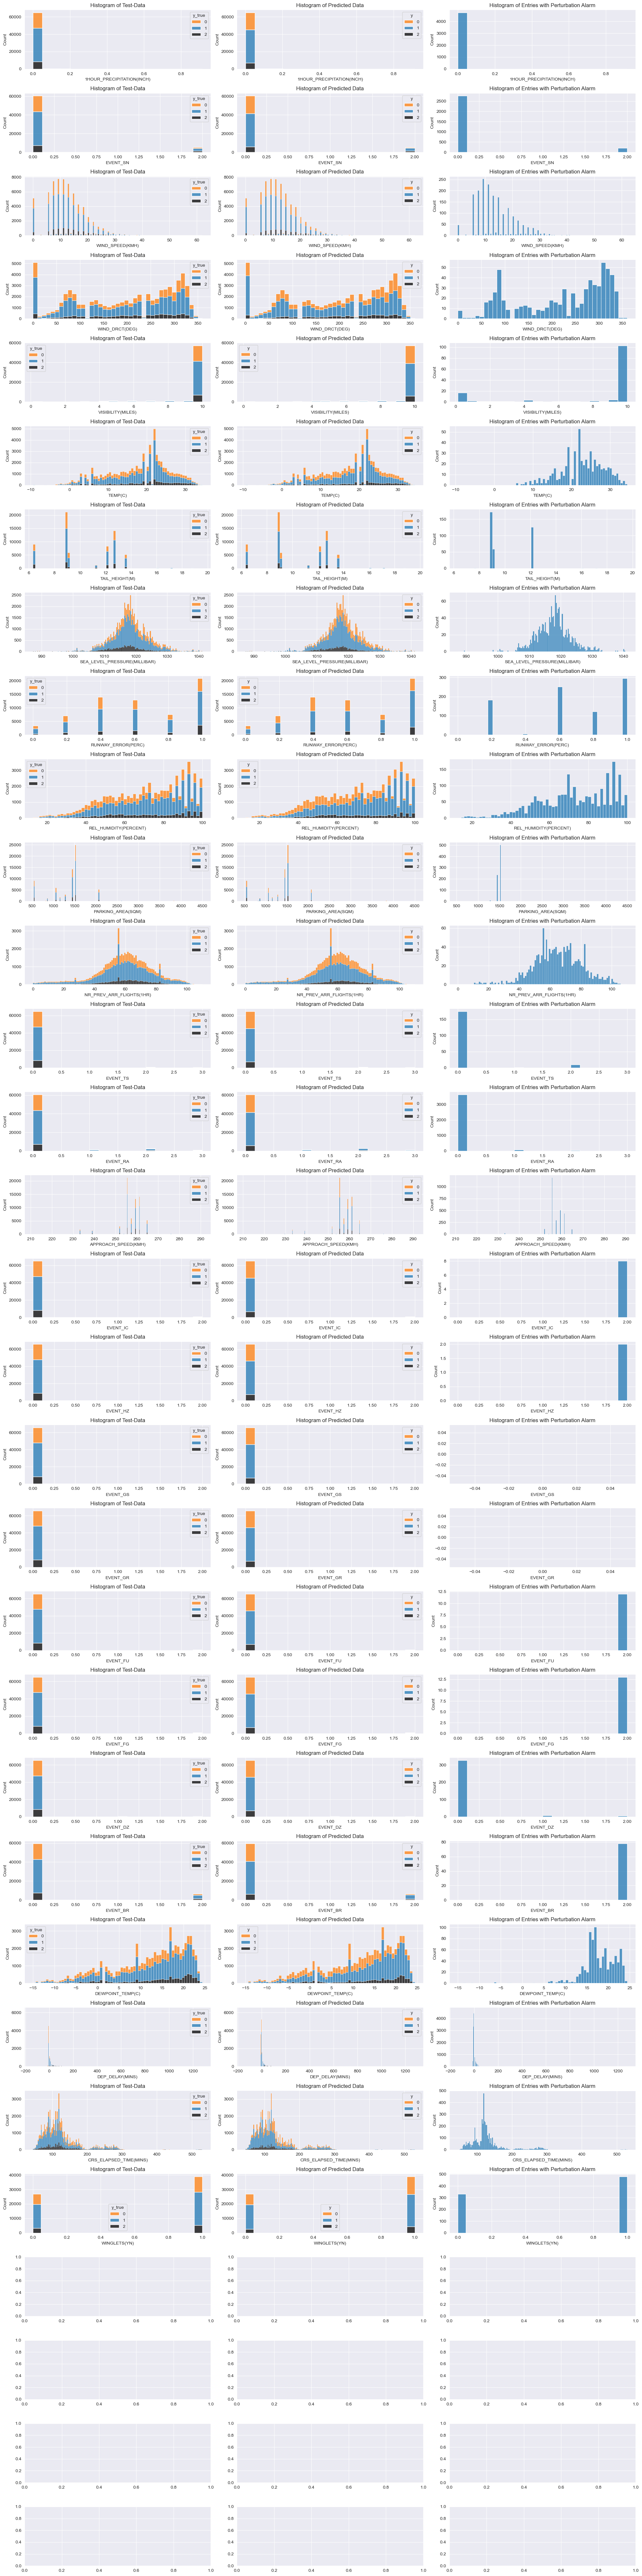

In [32]:
pert_view_alert = pert_view[pert_view["pert_alarm"] == True]

fig, axes = plt.subplots(len(pert_cols),3, figsize=(20,80))

count = 0
for col in cols:
    p_row = int(count / 3)
    bins = np.histogram_bin_edges(pert_view[pert_view["column"] == col]["val"], bins='auto')
    ax = sns.histplot(data = pert_view[pert_view["column"] == col], x = "val", hue="y_true", multiple="stack", ax=axes[p_row][0], bins=bins, palette = ["C1", "C0", "k"])
    axes[p_row][0].set_title("Histogram of Test-Data")
    ax.set(xlabel=col)
    ax = sns.histplot(data = pert_view[pert_view["column"] == col], x = "val", hue="y", multiple="stack", ax=axes[p_row][1], bins=bins, palette = ["C1", "C0", "k"])
    axes[p_row][1].set_title("Histogram of Predicted Data")
    ax.set(xlabel=col)
    ax = sns.histplot(data = pert_view_alert[pert_view_alert["column"] == col], x = "val", multiple="stack", ax=axes[p_row][2], bins = bins)
    axes[p_row][2].set_title("Histogram of Entries with Perturbation Alarm")
    ax.set(xlabel=col)
    count += 3
fig.tight_layout()
pert_view.groupby("idx").first()

In [33]:
def to_set(x):

    return set(x)

pert_view["y_outcomes"] = list(pert_outcomes[["pert_id" , "y"]].groupby("pert_id")["y"].apply(set).reset_index()["y"].to_numpy())
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes
pert_id,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False,{1}
...,...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396,False,False,{0}
WINGLETS(YN)<9998430>,2,1,2,WINGLETS(YN),1.000,9998430,False,False,{2}
WINGLETS(YN)<9998460>,1,1,1,WINGLETS(YN),0.000,9998460,False,False,{1}


In [34]:
def find_diff(x):
    return list(x.y_outcomes.difference({x.y}))

pert_view["changed_to"] = pert_view.apply( find_diff , axis = "columns")

In [35]:
def is_good_change(x):
    return x.y_true in x.changed_to

pert_view["corrected"] = list(pert_view[["y_true", "changed_to"]].apply(is_good_change, axis = "columns"))

In [36]:
def is_bad_change(x):
    if not x.class_error and x.changed_to:
        return True
    return False

pert_view["worsened"] = list(pert_view[["class_error", "changed_to"]].apply(is_bad_change, axis = "columns"))

In [37]:
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False,{1},[],False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396,False,False,{0},[],False,False
WINGLETS(YN)<9998430>,2,1,2,WINGLETS(YN),1.000,9998430,False,False,{2},[],False,False
WINGLETS(YN)<9998460>,1,1,1,WINGLETS(YN),0.000,9998460,False,False,{1},[],False,False


In [38]:
def get_first(x):
    return x[0]

def find_union(x):
    return set().union(*x)

def get_indicator(x):
    return sum(x) / len(pert_cols)

pert_test_results_th3 = pert_view[pert_view["level"] >= 3]
pert_test_results_th3 = pert_test_results_th3.groupby("idx").agg({"y_true" : get_first, "y" : pd.Series.mode, "pert_alarm" : max, "y_outcomes" : find_union, "changed_to" : find_union, "corrected" : get_indicator , "worsened" : get_indicator})
pert_test_results_th2 = pert_view[pert_view["level"] >= 2]
pert_test_results_th2 = pert_test_results_th2.groupby("idx").agg({"y_true" : get_first, "y" : pd.Series.mode, "pert_alarm" : max, "y_outcomes" : find_union, "changed_to" : find_union, "corrected" : get_indicator , "worsened" : get_indicator})
pert_test_results = pert_view.groupby("idx").agg({"y_true" : get_first, "y" : pd.Series.mode, "pert_alarm" : max, "y_outcomes" : find_union, "changed_to" : find_union, "corrected" : get_indicator , "worsened" : get_indicator})
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10001243,1,1,True,"{0, 1}",{0},0.0,0.032258
10003947,1,1,False,{1},{},0.0,0.000000
10004727,1,1,False,{1},{},0.0,0.000000
10006126,1,1,False,{1},{},0.0,0.000000
10006791,1,1,False,{1},{},0.0,0.000000
...,...,...,...,...,...,...,...
9998396,0,0,True,"{0, 1}",{1},0.0,0.032258
9998430,2,2,False,{2},{},0.0,0.000000
9998460,1,1,True,"{0, 1}",{0},0.0,0.032258


# Working with pert_test_results

In [39]:
pert_test_results[pert_test_results["pert_alarm"]]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10001243,1,1,True,"{0, 1}",{0},0.000000,0.032258
10007352,2,2,True,"{1, 2}",{1},0.000000,0.032258
10007455,1,1,True,"{1, 2}",{2},0.000000,0.032258
10007456,2,1,True,"{1, 2}",{2},0.032258,0.000000
10007505,1,1,True,"{1, 2}",{2},0.000000,0.032258
...,...,...,...,...,...,...,...
9998359,1,1,True,"{0, 1}",{0},0.000000,0.032258
9998375,1,1,True,"{0, 1}",{0},0.000000,0.032258
9998396,0,0,True,"{0, 1}",{1},0.000000,0.032258


In [40]:
pert_test_results[pert_test_results["pert_alarm"] == False]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10003947,1,1,False,{1},{},0.0,0.0
10004727,1,1,False,{1},{},0.0,0.0
10006126,1,1,False,{1},{},0.0,0.0
10006791,1,1,False,{1},{},0.0,0.0
10007195,2,2,False,{2},{},0.0,0.0
...,...,...,...,...,...,...,...
9998258,1,1,False,{1},{},0.0,0.0
9998351,1,1,False,{1},{},0.0,0.0
9998376,1,1,False,{1},{},0.0,0.0


In [41]:
pert_test_results_th2[pert_test_results_th2["pert_alarm"]]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10012474,1,2,True,"{1, 2}",{1},0.032258,0.000000
10026093,1,0,True,"{0, 1}",{1},0.225806,0.000000
10032433,1,1,True,"{0, 1}",{0},0.000000,0.032258
10033431,2,2,True,"{1, 2}",{1},0.000000,0.129032
10035655,1,1,True,"{0, 1}",{0},0.000000,0.032258
...,...,...,...,...,...,...,...
9995297,1,0,True,"{0, 1}",{1},0.032258,0.000000
9996537,0,0,True,"{0, 1}",{1},0.000000,0.032258
9997432,1,0,True,"{0, 1}",{1},0.032258,0.000000


In [42]:
#TODO CREATE NEW FUNCTIONS FOR TH2
pert_test_results = pert_test_results_th2

In [43]:
alarm = print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == True]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == True]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 7249
Accuracy: 0.49897
Precision-µ: 0.49897
Recall-µ: 0.49897
F1-Score-µ: 0.49897
=
Precision-M: 0.51540
Recall-M: 0.50996
F1-Score-M: 0.48517
--------------------
Measures for label '0'
Number of entries: 2980
Precision score: 0.46275
Recall score: 0.76074
--------------------
Measures for label '1'
Number of entries: 3907
Precision score: 0.58785
Recall score: 0.30228
--------------------
Measures for label '2'
Number of entries: 362
Precision score: 0.49560
Recall score: 0.46685


In [44]:
no_alarm = print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == False]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == False]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 58552
Accuracy: 0.76342
Precision-µ: 0.76342
Recall-µ: 0.76342
F1-Score-µ: 0.76342
=
Precision-M: 0.77451
Recall-M: 0.72888
F1-Score-M: 0.74872
--------------------
Measures for label '0'
Number of entries: 14859
Precision score: 0.62313
Recall score: 0.61525
--------------------
Measures for label '1'
Number of entries: 35463
Precision score: 0.79274
Recall score: 0.83081
--------------------
Measures for label '2'
Number of entries: 8230
Precision score: 0.90767
Recall score: 0.74058


In [45]:
pert_test_results[pert_test_results["corrected"] > 0.25]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10082641,1,0,True,"{0, 1}",{1},0.258065,0.0
10088834,1,0,True,"{0, 1}",{1},0.290323,0.0
10213410,1,0,True,"{0, 1}",{1},0.258065,0.0
10248713,1,0,True,"{0, 1}",{1},0.290323,0.0
10288857,1,0,True,"{0, 1}",{1},0.258065,0.0
...,...,...,...,...,...,...,...
9870181,0,1,True,"{0, 1}",{0},0.258065,0.0
9872914,1,0,True,"{0, 1}",{1},0.258065,0.0
9892770,1,0,True,"{0, 1}",{1},0.290323,0.0


In [46]:
pert_test_results[pert_test_results["worsened"] > 0]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10032433,1,1,True,"{0, 1}",{0},0.0,0.032258
10033431,2,2,True,"{1, 2}",{1},0.0,0.129032
10035655,1,1,True,"{0, 1}",{0},0.0,0.032258
10042406,1,1,True,"{0, 1}",{0},0.0,0.064516
10042426,0,0,True,"{0, 1}",{1},0.0,0.193548
...,...,...,...,...,...,...,...
9981281,1,1,True,"{0, 1}",{0},0.0,0.096774
9983451,1,1,True,"{0, 1}",{0},0.0,0.096774
9995030,1,1,True,"{0, 1}",{0},0.0,0.193548


[(0.0, 0.25)]

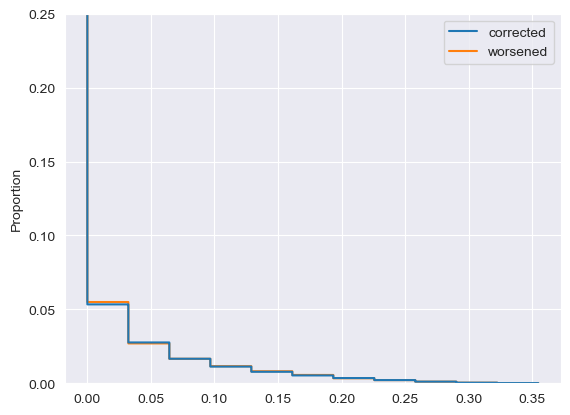

In [47]:
ax = sns.ecdfplot(data=pert_test_results[["corrected", "worsened"]], complementary=True)
ax.set(ylim=(0,0.25))

In [48]:
pert_test_results[pert_test_results["y_outcomes"].map(len) > 2]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
6997223,2,1,True,"{0, 1, 2}","{0, 2}",0.064516,0.00000
7028933,2,2,True,"{0, 1, 2}","{0, 1}",0.000000,0.16129


In [49]:
pert_test_results["correct"] = pert_test_results["y_true"] == pert_test_results["y"]
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct
idx,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True
10003947,1,1,False,{1},{},0.0,0.0,True
10004727,1,1,False,{1},{},0.0,0.0,True
10006126,1,1,False,{1},{},0.0,0.0,True
10006791,1,1,False,{1},{},0.0,0.0,True
...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True
9998430,2,2,False,{2},{},0.0,0.0,True
9998460,1,1,False,{1},{},0.0,0.0,True


<AxesSubplot:xlabel='pert_alarm', ylabel='count'>

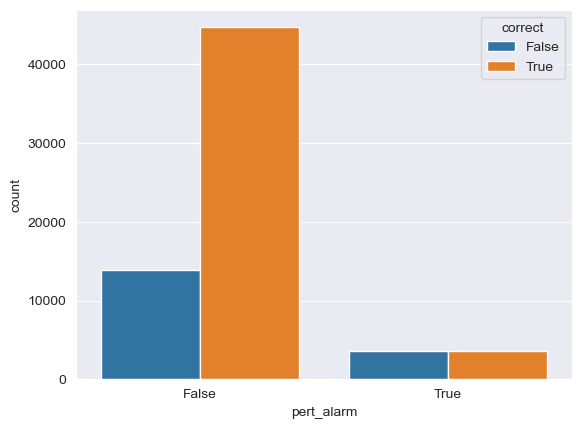

In [50]:
sns.countplot(data = pert_test_results, x="pert_alarm", hue="correct")

In [51]:
def correct_mistakes(row):
    if row.pert_alarm:
        return row.y_true
    else:
        return row.y

def force_mistakes(row):
    if row.worsened >= 0.3 and row.changed_to:
        return random.sample(row.changed_to,1)[0]
    else:
        return row.y

def force_corrections(row):
    if row.corrected >= 0.3:
        return row.y_true
    else:
        return row.y

pert_test_results["y_corrected"] = pert_test_results.apply(correct_mistakes, axis="columns")
pert_test_results["y_forced_mistake"] = pert_test_results.apply(force_mistakes, axis="columns")
pert_test_results["y_forced_correction"] = pert_test_results.apply(force_corrections, axis="columns")

C:\Users\chrig\AppData\Local\Temp\ipykernel_6040\462870279.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(row.changed_to,1)[0]


In [52]:
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True,1,1,1
10003947,1,1,False,{1},{},0.0,0.0,True,1,1,1
10004727,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006126,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006791,1,1,False,{1},{},0.0,0.0,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True,0,0,0
9998430,2,2,False,{2},{},0.0,0.0,True,2,2,2
9998460,1,1,False,{1},{},0.0,0.0,True,1,1,1


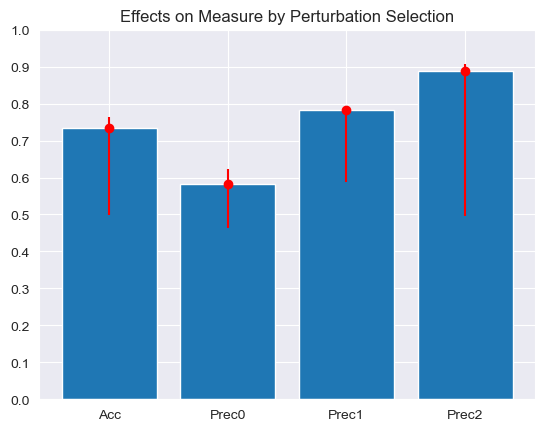

In [53]:
y_errormin = [alarm.get("acc"), alarm.get("prec0"), alarm.get("prec1"), alarm.get("prec2")]
y_errormax = [no_alarm.get("acc"), no_alarm.get("prec0"), no_alarm.get("prec1"), no_alarm.get("prec2")]
y_error = [y_errormin, y_errormax]
y = [real.get("acc"), real.get("prec0"), real.get("prec1"), real.get("prec2")]
for c, v in enumerate(y_errormin):
    y_errormin[c] = y[c] - v
for c, v in enumerate(y_errormax):
    y_errormax[c] = v - y[c]
x = ["Acc", "Prec0", "Prec1", "Prec2"]
plt.bar(x,y)
plt.errorbar(x,y, yerr=y_error, fmt='o', color="r")

plt.yticks(np.arange(start=0, stop=1.1, step = 0.1))
plt.title("Effects on Measure by Perturbation Selection")
plt.show()

In [54]:
print(f"Real values {real}")
print(f"Alarmed values {alarm}")
print(f"Non-alarmed values {no_alarm}")

Real values {'acc': 0.7342897524353733, 'prec0': 0.5829841594276954, 'prec1': 0.7822335673261008, 'prec2': 0.8877551020408163}
Alarmed values {'acc': 0.4989653745344185, 'prec0': 0.4627474994896918, 'prec1': 0.5878546540567446, 'prec2': 0.49560117302052786}
Non-alarmed values {'acc': 0.7634239650225441, 'prec0': 0.6231340740235839, 'prec1': 0.7927406769628155, 'prec2': 0.9076693968726731}


In [55]:
# Scores when all alerted entries are corrected
print_measures(list(pert_test_results["y_corrected"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.78949
Precision-µ: 0.78949
Recall-µ: 0.78949
F1-Score-µ: 0.78949
=
Precision-M: 0.80387
Recall-M: 0.75955
F1-Score-M: 0.77898
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.68676
Recall score: 0.67952
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.81246
Recall score: 0.84760
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.91239
Recall score: 0.75151


{'acc': 0.7894864819683591,
 'prec0': 0.6867599569429494,
 'prec1': 0.8124558712536216,
 'prec2': 0.9123922566059065}

In [56]:
# Scores when all alerted entries discarded
print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == False]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == False]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 58552
Accuracy: 0.76342
Precision-µ: 0.76342
Recall-µ: 0.76342
F1-Score-µ: 0.76342
=
Precision-M: 0.77451
Recall-M: 0.72888
F1-Score-M: 0.74872
--------------------
Measures for label '0'
Number of entries: 14859
Precision score: 0.62313
Recall score: 0.61525
--------------------
Measures for label '1'
Number of entries: 35463
Precision score: 0.79274
Recall score: 0.83081
--------------------
Measures for label '2'
Number of entries: 8230
Precision score: 0.90767
Recall score: 0.74058


{'acc': 0.7634239650225441,
 'prec0': 0.6231340740235839,
 'prec1': 0.7927406769628155,
 'prec2': 0.9076693968726731}

In [57]:
#Scores when all strongly changed perturbations are corrected
print_measures(list(pert_test_results["y_forced_correction"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73470
Precision-µ: 0.73470
Recall-µ: 0.73470
F1-Score-µ: 0.73470
=
Precision-M: 0.75144
Recall-M: 0.71594
F1-Score-M: 0.73066
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.58361
Recall score: 0.63955
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.78241
Recall score: 0.77899
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.88829
Recall score: 0.72928


{'acc': 0.7347000805458883,
 'prec0': 0.5836104148549798,
 'prec1': 0.7824123679779581,
 'prec2': 0.8882903317266799}

In [58]:
#Scores when all strongly changed perturbations are changed to wrong entries
print_measures(list(pert_test_results["y_forced_mistake"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73391
Precision-µ: 0.73391
Recall-µ: 0.73391
F1-Score-µ: 0.73391
=
Precision-M: 0.75067
Recall-M: 0.71507
F1-Score-M: 0.72981
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.58259
Recall score: 0.63883
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.78179
Recall score: 0.77826
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.88763
Recall score: 0.72812


{'acc': 0.7339098189997113,
 'prec0': 0.5825878022595982,
 'prec1': 0.7817922024903041,
 'prec2': 0.887627695800227}

## Local Accuracy

In [59]:
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True,1,1,1
10003947,1,1,False,{1},{},0.0,0.0,True,1,1,1
10004727,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006126,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006791,1,1,False,{1},{},0.0,0.0,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True,0,0,0
9998430,2,2,False,{2},{},0.0,0.0,True,2,2,2
9998460,1,1,False,{1},{},0.0,0.0,True,1,1,1


In [60]:
# Finding corresponding indexes
correct_indexes = pert_test_results.index[pert_test_results['correct'] == True].tolist()
false_indexes = pert_test_results.index[pert_test_results['correct'] == False].tolist()
alarm_indexes = pert_test_results.index[pert_test_results['pert_alarm'] == True].tolist()

In [61]:
X_test

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
6386798,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
6824913,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.4
7556876,-2,86,51,0.000000,1.000000,-0.768842,-0.639439,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.2
10772416,162,95,84,0.000000,1.000000,0.480989,-0.876727,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,0.0
7282245,-11,181,63,-0.433884,-0.900969,-0.942641,-0.333807,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980295,-3,102,68,-0.433884,-0.900969,0.731354,-0.681998,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.8
9983451,-3,115,30,-0.433884,-0.900969,-0.342020,0.939693,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
7026317,54,86,75,0.781831,0.623490,-0.816642,0.577145,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
10352441,2,150,53,0.000000,1.000000,-0.980785,0.195090,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.4


In [62]:
# Find correct vs false fraction
frac_fc = len(false_indexes) / len(correct_indexes) 
frac_alarm = len(alarm_indexes) / len(X_test.index)
print(f"Fraction false vs. correct is: {frac_fc:.4f} (Rounded)")
print(f"Fraction alarm vs. no alarm is: {frac_alarm:.4f} (Rounded)")

Fraction false vs. correct is: 0.3619 (Rounded)
Fraction alarm vs. no alarm is: 0.1102 (Rounded)


In [63]:
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from main.utils import time_utils

# Scaling Test-Data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test, y_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Sample X_test
sample_idxs = list(pert_test_results.groupby("pert_alarm", group_keys=False).apply(lambda x: x.sample(frac = 0.1)).index.astype(int))
X_test_sampled = X_test_scaled.loc[sorted(sample_idxs)]
X_test_sampled.index = range(len(X_test_sampled.index))
X_test_sampled

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
0,-0.385003,-0.187056,-0.179549,-1.179173,0.876772,1.443730,-0.569405,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
1,1.719756,-1.037990,-0.669720,-1.179173,0.876772,-0.822171,-0.441928,0.335079,-1.654315,-1.808123,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
2,-0.234663,-0.735436,-0.560793,-1.179173,0.876772,-0.114233,-1.020770,0.335079,2.841814,5.472442,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
3,0.216357,-0.811074,-0.016159,-1.179173,0.876772,-0.952956,-0.204010,0.335079,-1.654315,-1.808123,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
4,-0.041369,-0.432882,1.454353,-1.179173,0.876772,1.358293,-0.666376,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,-0.277617,0.399143,0.582938,-1.179173,0.876772,1.199186,-0.810711,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6576,-0.299095,1.930824,-1.758988,-1.179173,0.876772,0.064905,-1.075010,1.281802,1.399947,1.611864,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6577,-0.170232,1.987552,-1.650062,-1.179173,0.876772,0.046107,-1.070582,0.335079,0.757280,0.359495,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6578,0.946579,-0.035779,-0.833110,-1.179173,0.876772,1.621898,-0.298438,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524


In [64]:
# Sample y_test
y_test_true_sampled = y_test.loc[sorted(sample_idxs)]
y_test_true_sampled.index = range(len(y_test_true_sampled.index))

y_test_pred_sampled = y_test_pred.copy()
y_test_pred_sampled.index = y_test.index
y_test_pred_sampled = y_test_pred_sampled.loc[sorted(sample_idxs)]
y_test_pred_sampled.index = range(len(y_test_pred_sampled.index))
y_test_pred_sampled

,0
0,1
1,2
2,1
3,2
4,1
...,...
6575,0
6576,0
6577,0
6578,2


In [65]:
def calc_manh_dist_matrix(X: pd.DataFrame):   
    X = X.to_numpy()
    n = X.shape[0]
    D = np.zeros((n,n))
    D_asym = np.zeros((n,n))
    start, start_str = time_utils.print_time()
    print(f"Start distance calc at {start_str}")
    for i in range(n):
        print(f"{i+1}/{n}:")
        for j in range(i,n):
            D[i,j] = distance.cityblock(X[i], X[j])
            D[j,i] =  D[i,j]
            D_asym[i,j] = D[i,j]
            D_asym[j,i] = np.nan
    end, end_str = time_utils.print_time()
    print(f"End distance calc at {end_str}\n Took time: {end-start}")
    return D, D_asym

In [66]:
distance_matrix, dist_matrix_asym = calc_manh_dist_matrix(X_test_sampled)
distance_matrix

Start distance calc at 2024_11_05 17:46
1/6580:
2/6580:
3/6580:
4/6580:
5/6580:
6/6580:
7/6580:
8/6580:
9/6580:
10/6580:
11/6580:
12/6580:
13/6580:
14/6580:
15/6580:
16/6580:
17/6580:
18/6580:
19/6580:
20/6580:
21/6580:
22/6580:
23/6580:
24/6580:
25/6580:
26/6580:
27/6580:
28/6580:
29/6580:
30/6580:
31/6580:
32/6580:
33/6580:
34/6580:
35/6580:
36/6580:
37/6580:
38/6580:
39/6580:
40/6580:
41/6580:
42/6580:
43/6580:
44/6580:
45/6580:
46/6580:
47/6580:
48/6580:
49/6580:
50/6580:
51/6580:
52/6580:
53/6580:
54/6580:
55/6580:
56/6580:
57/6580:
58/6580:
59/6580:
60/6580:
61/6580:
62/6580:
63/6580:
64/6580:
65/6580:
66/6580:
67/6580:
68/6580:
69/6580:
70/6580:
71/6580:
72/6580:
73/6580:
74/6580:
75/6580:
76/6580:
77/6580:
78/6580:
79/6580:
80/6580:
81/6580:
82/6580:
83/6580:
84/6580:
85/6580:
86/6580:
87/6580:
88/6580:
89/6580:
90/6580:
91/6580:
92/6580:
93/6580:
94/6580:
95/6580:
96/6580:
97/6580:
98/6580:
99/6580:
100/6580:
101/6580:
102/6580:
103/6580:
104/6580:
105/6580:
106/6580:
107/6580

array([[ 0.        , 23.84276407, 31.46298205, ..., 28.35455123,
        24.53493453, 25.19416723],
       [23.84276407,  0.        , 21.98488638, ..., 38.16400268,
        34.6510541 , 34.16189197],
       [31.46298205, 21.98488638,  0.        , ..., 41.95420862,
        44.38782534, 40.39525286],
       ...,
       [28.35455123, 38.16400268, 41.95420862, ...,  0.        ,
         8.24703633,  5.46945358],
       [24.53493453, 34.6510541 , 44.38782534, ...,  8.24703633,
         0.        ,  4.26549795],
       [25.19416723, 34.16189197, 40.39525286, ...,  5.46945358,
         4.26549795,  0.        ]])

In [67]:
np.fill_diagonal(distance_matrix, np.nan)
distance_matrix

array([[        nan, 23.84276407, 31.46298205, ..., 28.35455123,
        24.53493453, 25.19416723],
       [23.84276407,         nan, 21.98488638, ..., 38.16400268,
        34.6510541 , 34.16189197],
       [31.46298205, 21.98488638,         nan, ..., 41.95420862,
        44.38782534, 40.39525286],
       ...,
       [28.35455123, 38.16400268, 41.95420862, ...,         nan,
         8.24703633,  5.46945358],
       [24.53493453, 34.6510541 , 44.38782534, ...,  8.24703633,
                nan,  4.26549795],
       [25.19416723, 34.16189197, 40.39525286, ...,  5.46945358,
         4.26549795,         nan]])

In [68]:
distance_list = distance_matrix.flatten()
distance_list = list(distance_list[~np.isnan(distance_list)])

print(f"Number of entries: {len(distance_list)}")

Number of entries: 43289820


<AxesSubplot:>

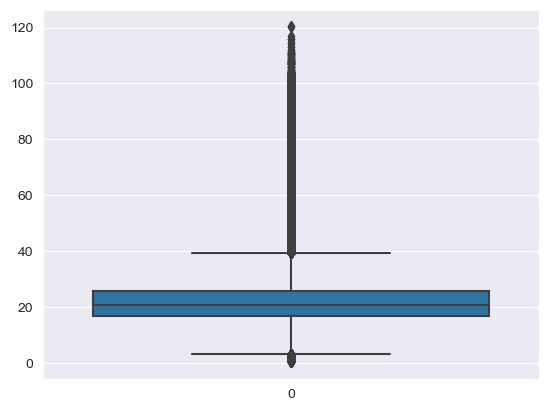

In [69]:
sns.boxplot(distance_list)

In [70]:
neigh_thresh = np.percentile(distance_list,0.2)
neigh_thresh

6.669282681703149

In [71]:
np.fill_diagonal(dist_matrix_asym, 0)
boolean_mask = np.where((dist_matrix_asym < neigh_thresh) & (~np.isnan(dist_matrix_asym)), True, False)
boolean_mask

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

In [72]:
true_indices_list = []
for row in boolean_mask:
    true_indices = np.where(row)[0]
    true_indices_list.append(true_indices.tolist())
true_indices_list

[[0, 4, 9, 17],
 [1, 3],
 [2],
 [3, 5],
 [4],
 [5, 16],
 [6, 8, 10, 12, 1590],
 [7],
 [8, 10, 14],
 [9, 12],
 [10, 12, 14, 1590],
 [11, 14],
 [12, 1590],
 [13],
 [14],
 [15, 29],
 [16],
 [17],
 [18],
 [19],
 [20, 5731],
 [21],
 [22],
 [23],
 [24, 31],
 [25, 6389],
 [26, 31],
 [27, 28],
 [28],
 [29, 31, 5725],
 [30],
 [31],
 [32],
 [33],
 [34, 6396],
 [35, 1753],
 [36, 44, 665],
 [37, 39],
 [38,
  41,
  52,
  1626,
  1631,
  1757,
  2140,
  2142,
  2143,
  2147,
  2148,
  2150,
  2887,
  3729,
  4116,
  5723,
  6418,
  6423],
 [39],
 [40, 1761],
 [41,
  43,
  52,
  366,
  1065,
  1067,
  1623,
  1626,
  1630,
  1631,
  1757,
  1764,
  2140,
  2142,
  2143,
  2147,
  2148,
  2150,
  2682,
  2867,
  2887,
  3729,
  3861,
  3865,
  4621,
  5448,
  5453,
  5691,
  5723,
  6293,
  6418,
  6423],
 [42],
 [43, 48, 674, 2137, 2146, 2150, 4615],
 [44, 959, 1192, 1223, 2036, 4704, 5445],
 [45, 5196],
 [46, 47],
 [47, 50],
 [48, 49, 679, 2154, 2155, 2156, 2167, 2879, 3732, 4806, 4947],
 [49, 679, 

In [73]:
np.median([len(elem) for elem in true_indices_list])

4.0

In [74]:
X_test_sampled

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
0,-0.385003,-0.187056,-0.179549,-1.179173,0.876772,1.443730,-0.569405,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
1,1.719756,-1.037990,-0.669720,-1.179173,0.876772,-0.822171,-0.441928,0.335079,-1.654315,-1.808123,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
2,-0.234663,-0.735436,-0.560793,-1.179173,0.876772,-0.114233,-1.020770,0.335079,2.841814,5.472442,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
3,0.216357,-0.811074,-0.016159,-1.179173,0.876772,-0.952956,-0.204010,0.335079,-1.654315,-1.808123,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
4,-0.041369,-0.432882,1.454353,-1.179173,0.876772,1.358293,-0.666376,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,-0.277617,0.399143,0.582938,-1.179173,0.876772,1.199186,-0.810711,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6576,-0.299095,1.930824,-1.758988,-1.179173,0.876772,0.064905,-1.075010,1.281802,1.399947,1.611864,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6577,-0.170232,1.987552,-1.650062,-1.179173,0.876772,0.046107,-1.070582,0.335079,0.757280,0.359495,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6578,0.946579,-0.035779,-0.833110,-1.179173,0.876772,1.621898,-0.298438,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524


In [75]:
pert_test_results.index = pert_test_results.index.astype(int)
pert_test_results_sampled = pert_test_results.loc[sample_idxs]
pert_test_results_sampled.index = range(len(pert_test_results_sampled.index))
pert_test_results_sampled

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
0,0,1,False,{1},{},0.000000,0.000000,False,1,1,1
1,2,2,False,{2},{},0.000000,0.000000,True,2,2,2
2,0,0,False,{0},{},0.000000,0.000000,True,0,0,0
3,0,1,False,{1},{},0.000000,0.000000,False,1,1,1
4,1,1,False,{1},{},0.000000,0.000000,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6575,1,0,True,"{0, 1}",{1},0.064516,0.000000,False,1,0,0
6576,1,1,True,"{0, 1}",{0},0.000000,0.032258,True,1,1,1
6577,1,0,True,"{0, 1}",{1},0.096774,0.000000,False,1,0,0
6578,1,0,True,"{0, 1}",{1},0.064516,0.000000,False,1,0,0


In [76]:
res_list = []
for list in true_indices_list:
    res_list.append(accuracy_score(y_test_true_sampled.loc[list], y_test_pred_sampled.loc[list]))
res_list 

[0.75,
 0.5,
 1.0,
 0.0,
 0.0,
 0.5,
 0.8,
 0.0,
 0.6666666666666666,
 1.0,
 0.5,
 0.0,
 0.5,
 1.0,
 0.0,
 0.5,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.6666666666666666,
 0.5,
 0.6666666666666666,
 0.0,
 1.0,
 0.53125,
 1.0,
 0.5714285714285714,
 0.7142857142857143,
 1.0,
 0.0,
 0.5,
 0.6363636363636364,
 0.5,
 1.0,
 0.625,
 0.7647058823529411,
 0.75,
 0.6,
 0.625,
 0.7142857142857143,
 1.0,
 0.8,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9166666666666666,
 0.7777777777777778,
 0.5,
 0.7142857142857143,
 1.0,
 1.0,
 0.6,
 0.8333333333333334,
 1.0,
 0.3333333333333333,
 0.2857142857142857,
 0.0,
 0.6,
 0.75,
 0.6666666666666666,
 0.75,
 0.7142857142857143,
 1.0,
 0.8888888888888888,
 0.6363636363636364,
 1.0,
 1.0,
 1.0,
 0.6153846153846154,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9,
 0.5,
 0.7777777777777778,
 0.0,
 0.5,
 0.75,
 0.5714285714285714,
 0.5,
 0.6,
 0.625,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 

In [77]:
alarm_idx = pert_test_results_sampled[pert_test_results_sampled["pert_alarm"] == True].index
no_alarm_idx = pert_test_results_sampled[pert_test_results_sampled["pert_alarm"] == False].index

alarm_acc = np.mean([res_list[i] for i in alarm_idx])
no_alarm_acc = np.mean([res_list[i] for i in no_alarm_idx]) 

In [78]:
alarm_acc

0.7093690331352336

In [79]:
no_alarm_acc

0.7388002961851481

In [80]:
X_test

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
6386798,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
6824913,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.4
7556876,-2,86,51,0.000000,1.000000,-0.768842,-0.639439,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.2
10772416,162,95,84,0.000000,1.000000,0.480989,-0.876727,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,0.0
7282245,-11,181,63,-0.433884,-0.900969,-0.942641,-0.333807,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980295,-3,102,68,-0.433884,-0.900969,0.731354,-0.681998,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.8
9983451,-3,115,30,-0.433884,-0.900969,-0.342020,0.939693,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
7026317,54,86,75,0.781831,0.623490,-0.816642,0.577145,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
10352441,2,150,53,0.000000,1.000000,-0.980785,0.195090,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.4


In [81]:
corr_df = pert_test_results[pert_test_results["corrected"] > 0.1]
corr_df

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10026093,1,0,True,"{0, 1}",{1},0.225806,0.0,False,1,0,0
10055239,1,0,True,"{0, 1}",{1},0.225806,0.0,False,1,0,0
10055554,1,0,True,"{0, 1}",{1},0.161290,0.0,False,1,0,0
10056225,0,1,True,"{0, 1}",{0},0.193548,0.0,False,0,1,1
10066841,0,1,True,"{0, 1}",{0},0.225806,0.0,False,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9979208,0,1,True,"{0, 1}",{0},0.161290,0.0,False,0,1,1
9979664,1,0,True,"{0, 1}",{1},0.193548,0.0,False,1,0,0
9980368,1,0,True,"{0, 1}",{1},0.290323,0.0,False,1,0,0


In [82]:
exp = pert_test_results[pert_test_results["pert_alarm"]]
exp_idx = exp.index.astype(str).tolist()
exp = pert_view[pert_view["idx"].isin(exp_idx)]
exp = exp[exp["level"] > 1]
exp

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10012474>,1,3,2,1HOUR_PRECIPITATION(INCH),0.475,10012474,False,True,{2},[],False,False
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10026093,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10032433>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10032433,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10033431>,2,3,2,1HOUR_PRECIPITATION(INCH),0.000,10033431,False,False,{2},[],False,False
1HOUR_PRECIPITATION(INCH)<10035655>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10035655,False,False,{1},[],False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9995297>,1,3,0,WIND_SPEED(KMH),13.890,9995297,False,True,{0},[],False,False
WIND_SPEED(KMH)<9996537>,0,3,0,WIND_SPEED(KMH),9.260,9996537,False,False,{0},[],False,False
WIND_SPEED(KMH)<9997432>,1,3,0,WIND_SPEED(KMH),12.964,9997432,False,True,{0},[],False,False


In [83]:
exp = exp[exp["pert_alarm"]]
exp

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10026093,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10042426>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042426,True,False,"{0, 1}",[1],False,True
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042665,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055239,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10055441>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055441,True,False,"{0, 1}",[1],False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9981281>,1,3,1,WIND_SPEED(KMH),9.260,9981281,True,False,"{0, 1}",[0],False,True
WIND_SPEED(KMH)<9983451>,1,3,1,WIND_SPEED(KMH),14.816,9983451,True,False,"{0, 1}",[0],False,True
WIND_SPEED(KMH)<9985126>,1,3,0,WIND_SPEED(KMH),13.890,9985126,True,True,"{0, 1}",[1],True,False


In [84]:
def select_random_row(group):
    return group.sample(n=1)

result = exp.groupby("column").apply(select_random_row)
result

,,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
column,pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH),1HOUR_PRECIPITATION(INCH)<9365042>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000000,9365042,True,True,"{0, 1}",[1],True,False
APPROACH_SPEED(KMH),APPROACH_SPEED(KMH)<9286591>,0,2,1,APPROACH_SPEED(KMH),259.280000,9286591,True,True,"{0, 1}",[0],True,False
DEWPOINT_TEMP(C),DEWPOINT_TEMP(C)<5737908>,0,3,1,DEWPOINT_TEMP(C),-13.277778,5737908,True,True,"{0, 1}",[0],True,False
PARKING_AREA(SQM),PARKING_AREA(SQM)<6848821>,0,2,0,PARKING_AREA(SQM),1517.837235,6848821,True,False,"{0, 1}",[1],False,True
REL_HUMIDITY(PERCENT),REL_HUMIDITY(PERCENT)<6468361>,0,3,1,REL_HUMIDITY(PERCENT),89.130000,6468361,True,True,"{0, 1}",[0],True,False
RUNWAY_ERROR(PERC),RUNWAY_ERROR(PERC)<6390410>,1,3,1,RUNWAY_ERROR(PERC),1.000000,6390410,True,False,"{0, 1}",[0],False,True
SEA_LEVEL_PRESSURE(MILLIBAR),SEA_LEVEL_PRESSURE(MILLIBAR)<9267641>,0,3,0,SEA_LEVEL_PRESSURE(MILLIBAR),1020.700000,9267641,True,False,"{0, 1}",[1],False,True
TAIL_HEIGHT(M),TAIL_HEIGHT(M)<6728834>,1,2,0,TAIL_HEIGHT(M),9.000744,6728834,True,True,"{0, 1}",[1],True,False
TEMP(C),TEMP(C)<9336157>,2,3,0,TEMP(C),22.777778,9336157,True,True,"{0, 1}",[1],False,False


In [85]:
X_csv = X_test.loc[result["idx"].astype(int)]
X_csv

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
9365042,-5,93,80,-0.781831,0.623490,-0.956305,0.292372,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.0
9286591,-6,119,78,0.781831,0.623490,-0.639439,-0.768842,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.8
5737908,0,134,81,0.000000,1.000000,-0.978148,0.207912,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.2
6848821,2,130,48,-0.433884,-0.900969,-0.362438,0.932008,259.280,12.100560,1517.837235,...,0,0,0,0,0,0,0,0,0,0.4
6468361,-1,211,41,0.781831,0.623490,-0.134851,-0.990866,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,1.0
6390410,-10,59,60,0.433884,-0.900969,0.342020,-0.939693,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
9267641,-3,168,50,0.000000,1.000000,-0.207912,-0.978148,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
6728834,-3,124,42,-0.433884,-0.900969,-0.173648,-0.984808,255.576,9.000744,1525.176514,...,0,2,0,0,0,0,0,0,0,0.4
9336157,-12,134,72,-0.433884,-0.900969,0.803857,-0.594823,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.8
10835469,-3,77,59,-0.433884,-0.900969,-0.975342,-0.220697,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6


In [86]:
X_csv.to_csv("pert_cases_rf.csv", sep=",")